In [1]:
import os
import matplotlib.pyplot as plt 
import cv2
import pandas as pd
import numpy as np
import gc
from functools import reduce
from skimage import io as skio

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import losses
from keras import metrics

Using TensorFlow backend.


In [3]:
input_shape = (250, 250, 3)

model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
           activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(512, activation='relu'),
    Dense(18, activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 250, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 256)       295168    
__________

In [4]:
save_model_name = "hackerthon_ss.model"

In [5]:
def getDf(path,W):
    o = {}
    o['name'] = []
    o['image'] = []
    for p in os.listdir(path):
        for filename in os.listdir(path+"/"+p):
            o['name'].append(p)
            oriimg = plt.imread(path+"/"+p+"/"+filename)
            height, width, depth = oriimg.shape
            imgScale = W/width if width>height else W/height
            newX,newY = width*imgScale, height*imgScale
            newSize = newX if newX>newY else newY
            newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))
            o['image'].append(newimg.tolist())
    return o

In [6]:
data = pd.DataFrame.from_dict(getDf('./data',250.))

In [7]:
def getTrainSet(d):
    a = d['image'].tolist()
    x_train = reduce(lambda x,y: np.concatenate((np.array(x).reshape(-1,250,250,3),np.array(y).reshape(-1,250,250,3)),axis=0),a)
    y_train = pd.get_dummies(data['name'])
    return x_train,y_train

In [8]:
x_train,y_train = getTrainSet(data)

In [9]:
model.compile(optimizer= optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.01, amsgrad=True),
              loss=losses.hinge,
              metrics=[metrics.categorical_accuracy])

In [10]:
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_acc')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)

In [11]:
hist = model.fit(x=x_train, y=y_train, validation_split=0.33,epochs=5,batch_size=32, callbacks=[model_checkpoint,reduce_lr])

Train on 216 samples, validate on 107 samples
Epoch 1/5
216/216 [==============================] - 537s 2s/step - loss: 0.9907 - categorical_accuracy: 0.1898 - val_loss: 1.0000 - val_categorical_accuracy: 0.0000e+00
Epoch 2/5
216/216 [==============================] - 710s 3s/step - loss: 0.9874 - categorical_accuracy: 0.2269 - val_loss: 1.0000 - val_categorical_accuracy: 0.0000e+00
Epoch 3/5
216/216 [==============================] - 663s 3s/step - loss: 0.9874 - categorical_accuracy: 0.2269 - val_loss: 1.0000 - val_categorical_accuracy: 0.0000e+00
Epoch 4/5
216/216 [==============================] - 550s 3s/step - loss: 0.9874 - categorical_accuracy: 0.2269 - val_loss: 1.0000 - val_categorical_accuracy: 0.0000e+00
Epoch 5/5
216/216 [==============================] - 450s 2s/step - loss: 0.9874 - categorical_accuracy: 0.2269 - val_loss: 1.0000 - val_categorical_accuracy: 0.0000e+00


In [12]:
hist.history

{'val_loss': [1.0, 1.0, 1.0, 1.0, 1.0],
 'val_categorical_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0],
 'loss': [0.9907329082489014,
  0.9873971320964672,
  0.987397140926785,
  0.9873971320964672,
  0.9873971497571027],
 'categorical_accuracy': [0.18981481481481483,
  0.22685185240374672,
  0.226851851299957,
  0.22685185185185186,
  0.22685185074806213],
 'lr': [0.01, 0.01, 0.01, 0.0019999999, 0.0019999999]}

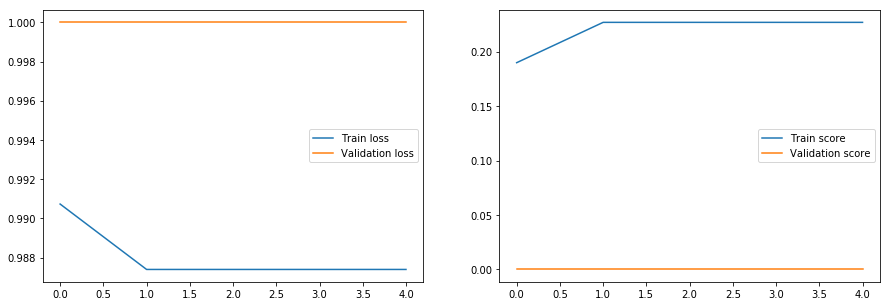

In [13]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(hist.epoch, hist.history["loss"], label="Train loss")
ax_loss.plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(hist.epoch, hist.history["categorical_accuracy"], label="Train score")
ax_score.plot(hist.epoch, hist.history["val_categorical_accuracy"], label="Validation score")
ax_score.legend()

In [16]:
def imgResize(url,W):
    oriimg = skio.imread(url)
    height, width, depth = oriimg.shape
    imgScale = W/width if width>height else W/height
    newX,newY = width*imgScale, height*imgScale
    newSize = newX if newX>newY else newY
    newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))
    return np.array(newimg).reshape(-1,int(newSize),int(newSize),3)

In [17]:
def getDf(path,W):
    o = {}
    o['name'] = []
    o['image'] = []
    for p in os.listdir(path):
        for filename in os.listdir(path+"/"+p):
            o['name'].append(p)
            oriimg = plt.imread(path+"/"+p+"/"+filename)
            height, width, depth = oriimg.shape
            imgScale = W/width if width>height else W/height
            newX,newY = width*imgScale, height*imgScale
            newSize = newX if newX>newY else newY
            newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))
            o['image'].append(newimg.tolist())
    return o

In [18]:
def getName(m,n,img):
    return pd.Categorical(n).categories[np.argmax(m.predict(img))]

In [19]:
image = imgResize("https://diag.tactri.gov.tw/public/UploadDgnsResultImage/6519/2d8e4ed2-833c-433c-ac7d-3401af085a78.jpg",250.)

In [20]:
# 萎凋病 
getName(model,data['name'],image)

'立枯病'

In [21]:
def imgResize2(i,W):
    oriimg = np.array(i)
    height, width, depth = oriimg.shape
    imgScale = W/width if width>height else W/height
    newX,newY = width*imgScale, height*imgScale
    newSize = newX if newX>newY else newY
    newimg = cv2.resize(oriimg,(int(newSize),int(newSize)))
    return np.array(newimg).reshape(-1,int(newSize),int(newSize),3)

In [22]:
j=0
for i in range(data.shape[0]):
    k = data.iloc[i]
    if k['name'] == getName(model,data['name'],imgResize2(k['image'],250)):
        j+=1

In [23]:
j/data.shape[0]

0.15170278637770898